# An introduction to Pound-Drever-Hall Frequency Stabilization

In this notebook I will explain the Pound-Drever-Hall technique of locking  laser to a stable reference cavity following closely the following paper: https://aapt.scitation.org/doi/10.1119/1.1286663
- The electric field incident on the cavity will be $E_{inc} = E_0 e^{i \omega t}$.
- The reflected electric field will be $E_{ref} = E_1 e^{i \omega t}$. 
- The reflected electric field can be written in terms of the incident electric field with the reflection coefficient $F(\omega)$ in the following way $E_{ref} = F(\omega) E_{inc}$
- For a symmetric cavity with no losses the reflection coefficient is 
\begin{equation}
F(\omega) = \frac{r \cdot \left( e^{i \frac{\omega}{\nu_{fsr}}}-1\right)}{1-r^2 \cdot e^{i \frac{\omega}{\nu_{fsr}}}}.
\end{equation}
- where $r$ is the amplitude reflection coefficient of each mirror, and where $\nu_{fsr} = c/2L$ is the free-spectral range of the cavity.

Alright, let's talk a bit more about the reflected field. Conceptually, you can think of the reflected field $E_{ref}$ as being a coherent sum of two fields: the promptly reflected field, which bounces off the first mirror and never enters the cavity $(E_{prf} = r \cdot E_{inc})$ and the leakage field ($E_{leak} = (1-r) \cdot E_{build-up}$). Because the amplitude of the build-up field near resonance is approximately the incident field multiplied by the number of bounces, $E_{build-up} = E_{inc} \cdot \frac{r}{1-r}$, at resonance these two fields are equal in amplitude and 180 degrees out of phase, and thus they destructively interfere and the total reflected power is zero.

Great, let's go ahead and see what the reflected intensity does as a function of wavelength. 

In [1]:
# Import some useful modules.
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time as time

In [2]:
# Let's define some useful functions that we will use later.

# First, define the reflection coefficien, which takes as its input the reflectivity of the mirrors (cavity is assumed to be symmetric), the detuning, and the free-spectral range.
def RefCoeff(r,detuning,FSR):
    return(r*(np.exp(1j*detuning/FSR)-1)/(1-r**2*np.exp(1j*detuning/FSR)))

# Next, let's define the Fourier transform, which takes as its input time data and the dataset you want to Fourier transform. 
def FourierTransform(t,ydata):
    dt = abs(t[2]-t[1]) # Define my smallest time step.
    
    df = 1.0/(abs(max(t)-min(t))) # Define my smallest frequency step.
    f_max = 1.0/dt # Define the frequency range. 
    f = np.arange(-f_max/2-df,f_max/2,df)
    
    FT = np.fft.fftshift(np.fft.fft(ydata)) # Take a Fast Fourier transform.
    PWRspectrum = np.real(np.conj(FT)*FT) # Find the power spectrum.
    norm = np.sum(PWRspectrum) # Find normalization
    return(f, PWRspectrum/norm) # This function returns the frequency values as well as the normalized frequency spectrum.

# Finally, let's define a frequency filtering function. This function takes in time data, the dataset you want to frequency filter, 
# and a frequency about which you want to filter and a filter width. 
def FrequencyFilter(t,ydata, f_0, sigma):
    dt = abs(t[2]-t[1])
    
    df = 1.0/(abs(max(t)-min(t)))
    f_max = 1.0/dt
    f= np.arange(-f_max/2-df,f_max/2,df)
    
    FT = np.fft.fftshift(np.fft.fft(ydata)) # Take a Fourier transform.
    PWRspectrum = np.real(np.conj(FT)*FT) # Find the power spectrum.
    norm = np.sum(PWRspectrum) # Find normalization
    E_T = np.fft.ifft(np.fft.ifftshift(FT)) #reverse fourier transform # Take an inverse FT
    
    # Filtering
    Filter_Function = np.exp(-(f-f_0)**2/2/sigma**2)
    Filtered_FT = FT*Filter_Function
    Filtered_PWRspectrum = np.real(np.conj(Filtered_FT)*Filtered_FT)
    Filtered_E_T = np.fft.ifft(np.fft.ifftshift(Filtered_FT))
    return(f, Filtered_E_T, PWRspectrum/norm, Filtered_PWRspectrum/norm) # this function returns the frequency values, filtered field values, the normalized frequency spectrum,
# and the normalized and filtered frequency spectrum. 

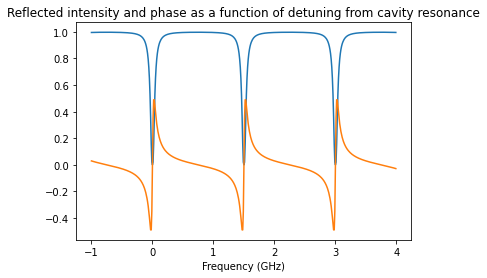

In [3]:
# Let's initialize some parameters.
r = 0.95 # Reflectivity of the mirrors
FSR = 1.5/2/np.pi #Giga rad/s
omega = np.arange(-1,4,1e-2) # range of frequencies
plt.figure()
plt.plot(omega, np.real(RefCoeff(r,omega,FSR))**2)
plt.plot(omega, np.imag(RefCoeff(r,omega,FSR)))
plt.title("Reflected intensity and phase as a function of detuning from cavity resonance")
plt.xlabel("Frequency (GHz)")
plt.show()

The earliest locking strategies simply involved trying to lock to the dip in reflected intensity (or the transmitted intensity peak). Locking to the slope had two problems. First, the capture range was small, if you jumped across resonance (this could be only kHz) suddenly the slope was inverted and the lock would fail. Second, any amplitude fluctuation would appear in the error signal and get fedback into the frequency stabilization coupling amplitude noise and frequency noise. The Pound-Drever-Hall technique avoids both of these pitfalls. The first step in PDH's technique is to write sidebands on the input field. This is most conveniently done by phase modulation, after which the input field takes the form: 
\begin{equation}
E_{inc} = E_0 e^{i \omega t + \beta \sin{\Omega t}}
\end{equation}
This can be (apparently) expanded to the more useable form: 
\begin{equation}
E_{inc} = E_0 J_0(\beta)e^{i \omega t} + E_0 J_1(\beta) e^{i(\omega + \Omega)t} - E_0 J_1(\beta) e^{i(\omega - \Omega)t},
\end{equation}
where $J_0$ and $J_1$ are Bessel functions. 

Let's go ahead and calculate a few Fourier transforms to visualize this all better.

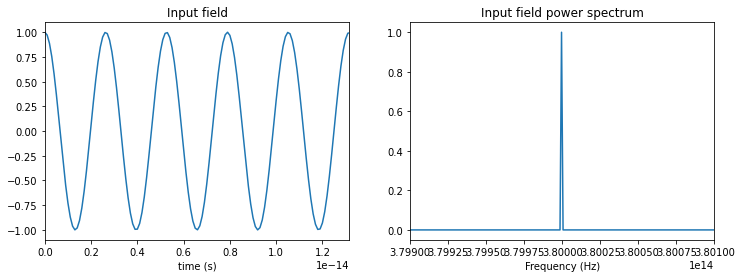

In [4]:
# First, let's calculate the Power spectrum of our input field with no modulation (note that I am only showing the positive frequency components here)
t = np.arange(0,1e-9,1e-16)
f_0 = 3.8e14 # Optical frequency corresponding to 780 nm
T_0 = 1/f_0 # Optical period
E_inc_nomodulation = np.exp(2*1j*np.pi*f_0*t)
f, PwrSpectrum = FourierTransform(t,E_inc_nomodulation)
fig1,axes1 = plt.subplots(1,2,figsize=(12,4))
axes1[0].plot(t,np.real(E_inc_nomodulation))
axes1[0].set_xlim(0,5*T_0)
axes1[0].set_title("Input field")
axes1[0].set_xlabel("time (s)")
axes1[1].plot(f,PwrSpectrum)
axes1[1].set_xlim(f_0 - 1e11,f_0 + 1e11)
axes1[1].set_title("Input field power spectrum")
axes1[1].set_xlabel("Frequency (Hz)")
plt.show()

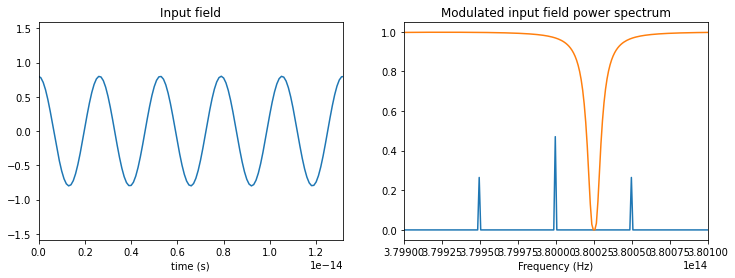

In [12]:
# Next, let's add a 50 GHz frequency modulation.
# With 1e-9 s duration, my frequency resolution is 1 GHz, so a 50 GHz modulation is clearly resolvable.
# Making the modulation much smaller would require that I use a longer duration, making my numpy arrays unwieldy in length (10 million is already quite long, 
# and the FT takes about 1 second to evaluate).
Omega = 50e9 # Modulation frequency
FSR2 = 200e9/2/np.pi # Let's set the free spectral range to be much larger than the modulation frequency
J_0 = 0.8
J_1 = np.sqrt(1-J_0**2)
E_inc_withmodulation = J_0*np.exp(1j*2*np.pi*(f_0)*t) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t) - J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)

fig2,axes2 = plt.subplots(1,2,figsize=(12,4))
axes2[0].plot(t,np.real(E_inc_withmodulation))
axes2[0].set_xlim(0,5*T_0)
axes2[0].set_title("Input field")
axes2[0].set_xlabel("time (s)")
axes2[1].plot(f,FourierTransform(t,E_inc_withmodulation)[1])
axes2[1].set_xlim(f_0 - 1e11,f_0 + 1e11)
axes2[1].set_title("Modulated input field power spectrum")
axes2[1].set_xlabel("Frequency (Hz)")

# I will also plot the reflection coefficient on top of this
axes2[1].plot(f, np.real(RefCoeff(.95,f-25e9,FSR2))**2)
plt.show()

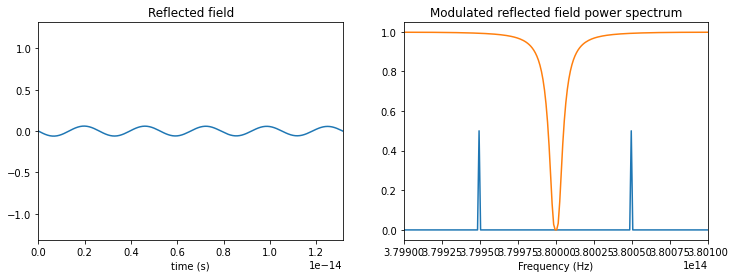

In [10]:
# Now let's calculate the reflected field when the cavity is on resonance with the carrier
cav_det = 0

E_ref_withmodulation1 = J_0*np.exp(1j*2*np.pi*f_0*t)*RefCoeff(r,f_0-cav_det, FSR2) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t)*RefCoeff(r,f_0+Omega - cav_det,FSR2) \
- J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)*RefCoeff(r,f_0 - Omega - cav_det,FSR2)

fig3,axes3 = plt.subplots(1,2,figsize=(12,4))
axes3[0].plot(t,np.real(E_ref_withmodulation1))
axes3[0].set_xlim(0,5*T_0)
axes3[0].set_title("Reflected field")
axes3[0].set_xlabel("time (s)")
axes3[1].plot(f,FourierTransform(t,E_ref_withmodulation1)[1])
axes3[1].set_xlim(f_0 - 1e11,f_0 + 1e11)
axes3[1].set_title("Modulated reflected field power spectrum")
axes3[1].set_xlabel("Frequency (Hz)")

# I will also plot the reflection coefficient on top of this
axes3[1].plot(f, np.real(RefCoeff(r,f - cav_det,FSR2))**2)
plt.show()

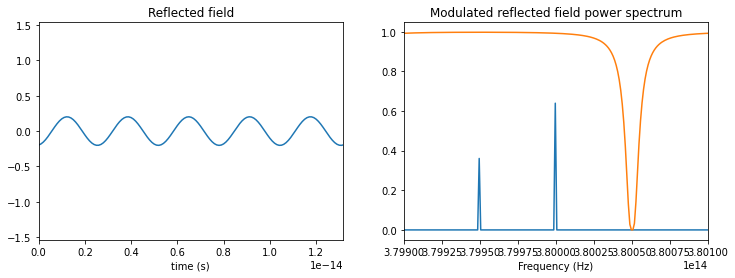

In [12]:
# Next let's calculate E_ref_withmodulation when the cavity is on resonance with the +50 GHz sideband
cav_det = 50e9

E_ref_withmodulation2 = J_0*np.exp(1j*2*np.pi*f_0*t)*RefCoeff(r,f_0-cav_det, FSR2) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t)*RefCoeff(r,f_0+Omega - cav_det,FSR2) \
- J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)*RefCoeff(r,f_0 - Omega - cav_det,FSR2)

fig4,axes4 = plt.subplots(1,2,figsize=(12,4))
axes4[0].plot(t,np.real(E_ref_withmodulation2))
axes4[0].set_xlim(0,5*T_0)
axes4[0].set_title("Reflected field")
axes4[0].set_xlabel("time (s)")
axes4[1].plot(f,FourierTransform(t,E_ref_withmodulation2)[1])
axes4[1].set_xlim(f_0 - 1e11,f_0 + 1e11)
axes4[1].set_title("Modulated reflected field power spectrum")
axes4[1].set_xlabel("Frequency (Hz)")

# I will also plot the reflection coefficient on top of this
axes4[1].plot(f, np.real(RefCoeff(r,f - cav_det,FSR2))**2)
plt.show()

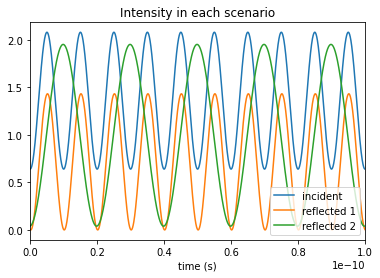

In [13]:
# Alright great, so that is what is happening to the electric field, but what am I going to detect? Well, I'm going to detect the intensity as a voltage with a photodiode.
# So what does the intensity look like for these three cases
plt.figure()
plt.plot(t,np.real(E_inc_withmodulation*np.conjugate(E_inc_withmodulation)), label = "incident")
plt.plot(t,np.real(E_ref_withmodulation1*np.conjugate(E_ref_withmodulation1)), label = "reflected 1")
plt.plot(t,np.real(E_ref_withmodulation2*np.conjugate(E_ref_withmodulation2)), label = "reflected 2")
plt.title("Intensity in each scenario")
plt.xlabel("time (s)")
plt.xlim(0,1e-10)
plt.legend(loc = "lower right")
plt.show()

Conceptually, what is going to happen is that the photodiode is going to detect the beating illustrated in the previous plot, producing a voltage proportional to the reflected intensity. The photodiode signal, therefore, will have the following form: 
\begin{equation}
    V(t) \propto I_{ref}(t) = |E_{ref}(t)|^2 = |E_0|^2 |F(\omega) J_0 e^{i \omega t} + F(\omega + \Omega) J_1 e^{i(\omega + \Omega)t} - F(\omega - \Omega) J_1 e^{i(\omega-\Omega)t}|^2.
\end{equation}
Expanding, the reflected intensity can be expressed
\begin{equation}
    |E_{ref}(t)|^2 = |E_0|^2 \left( |F(\omega) J_0 |^2 + |F(\omega + \Omega) J_1|^2 + |F(\omega - \Omega) J_1|^2 + F(\omega)F^*(\omega+\Omega) e^{i \Omega t} + F(\omega)F^*(\omega-\Omega) e^{-i \Omega t} + F(\omega + \Omega)F^*(\omega)e^{-i \Omega t} + F(\omega - \Omega)F^*(\omega) e^{i \Omega t} + 2 \Omega \textrm{ terms} \right).
\end{equation}
After some algebra, this can be simplified to the following
\begin{equation}
    |E_{ref}(t)|^2 = \textrm{Const.} + 2 J_0 J_1 \left(\mathcal{R}e[F(\omega)F^*(\omega+\Omega) - F^*(\omega)F(\omega-\Omega)]\cos{\Omega t} + \mathcal{I}m[F(\omega)F^*(\omega+\Omega) - F^*(\omega)F(\omega-\Omega)] \sin{\Omega t} \right) + 2 \Omega \textrm{ terms}.
\end{equation}
Mixing and lowpass filtering is going to mean we can disregard the constant and $2 \Omega$ terms. Looking closely at what remains, we can see it takes the form of real and imaginary parts of $F(\omega)F^*(\omega+\Omega) - F^*(\omega)F(\omega-\Omega)$. It is actually relatively easy to evaluate this formula for the situation we are considering, where at most only one of the three frequency components can be resonant with the cavity. Let's consider the case where the carrier is resonant with the cavity. In this case, $F(\omega + \Omega) \approx F(\omega - \Omega) = -1$. Now, all that remains is the real and imaginary parts of $F^*(\omega) - F(\omega)$. Of course, near resonance we already know that the real part of $F(\omega)$ is zero, and the imaginary part is linear in $\omega$. From this, we can conclude that our error signal around cavity resonance will be linear in $\omega$, just as desired.

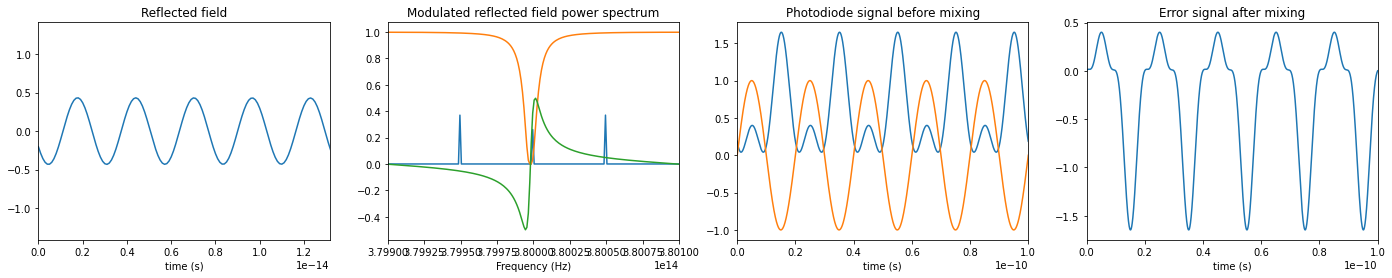

In [537]:
# Great, so let's try an arbitrary detuning
cav_det = -2e9 #2 GHz

E_ref_detuned = J_0*np.exp(1j*2*np.pi*f_0*t)*RefCoeff(r,f_0-cav_det, FSR2) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t)*RefCoeff(r,f_0+Omega - cav_det,FSR2) \
- J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)*RefCoeff(r,f_0 - Omega - cav_det,FSR2)

fig5,axes5 = plt.subplots(1,4,figsize=(24,4))
axes5[0].plot(t,np.real(E_ref_detuned))
axes5[0].set_xlim(0,5*T_0)
axes5[0].set_title("Reflected field")
axes5[0].set_xlabel("time (s)")
axes5[1].plot(f,FourierTransform(t,E_ref_detuned)[1])
axes5[1].set_xlim(f_0 - 1e11,f_0 + 1e11)
axes5[1].set_title("Modulated reflected field power spectrum")
axes5[1].set_xlabel("Frequency (Hz)")

# I will also plot the reflection coefficient on top of this.
axes5[1].plot(f, np.real(RefCoeff(r,f - cav_det,FSR2))**2)
axes5[1].plot(f, np.imag(RefCoeff(r,f - cav_det,FSR2)))

# And now let's plot the signal on the photodiode and compare it to the initial RF drive ~sin(2 * pi Omega t).
photodiode_signal = np.real(E_ref_detuned*np.conjugate(E_ref_detuned))
axes5[2].plot(t, photodiode_signal)
axes5[2].plot(t,np.sin(2*np.pi*Omega*t))
axes5[2].set_xlim(0,1e-10)
axes5[2].set_title("Photodiode signal before mixing")
axes5[2].set_xlabel("time (s)")

# The error signal is produced by multiplying the photodiode signal by sin(2 * pi *Omega t)
Error_signal = photodiode_signal*np.sin(2*np.pi*Omega*t)
axes5[3].plot(t,Error_signal)
axes5[3].set_title("Error signal after mixing")
axes5[3].set_xlabel("time (s)")
axes5[3].set_xlim(0,1e-10)
plt.show()

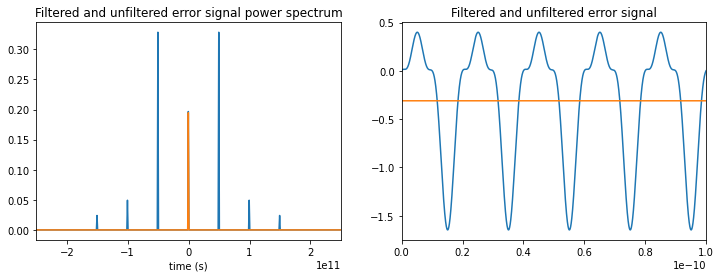

Lowpass filtered error signal is -0.31 V
Mean of my error signal is -0.31 V


In [543]:
# The final step is to lowpass filter the error signal at some frequency f_lowpass << Omega. 
# Note that I don't actually need to lowpass filter in my idealized example. Because I have no noise I can just calculate the mean of my error signal.
f_lowpass = 5e9 # 5 GHz << 50 GHz
f, Filtered_ErrorSignal, ErrorSignalPwrSpectrum, FilteredPwrSpectrum = FrequencyFilter(t,Error_signal, 0, f_lowpass)
fig6,axes6 = plt.subplots(1,2,figsize=(12,4))
axes6[0].plot(f,ErrorSignalPwrSpectrum)
axes6[0].plot(f13,FilteredPwrSpectrum)
axes6[0].set_xlim(-5*Omega,5*Omega)
axes6[0].set_title("Filtered and unfiltered error signal power spectrum")
axes6[0].set_xlabel("Frequency (Hz)")
axes6[1].plot(t,Error_signal)
axes6[1].plot(t,Filtered_ErrorSignal) 
axes6[1].set_xlim(0,1e-10)
axes6[1].set_title("Filtered and unfiltered error signal")
axes6[0].set_xlabel("time (s)")
plt.show()
print("Lowpass filtered error signal is %1.2f V" %(np.mean(Filtered_ErrorSignal)))
print("Mean of my error signal is %1.2f V" %np.mean(Error_signal)) # I don't actually need to apply the filtering function, as I've got no noise in my idealized example.

In [5]:
# Alright, I'd like to define a function which I can iterate over
def PDH(t, r, f_0, FSR, Omega, J_0, J_1, det_cav, ram_amp, ram_phase):
    E_reflected = (J_0*np.exp(1j*2*np.pi*f_0*t)*RefCoeff(r,f_0 - det_cav,FSR) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t)*RefCoeff(r,f_0+Omega - det_cav,FSR) \
    - J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)*RefCoeff(r,f_0 - Omega - det_cav,FSR))*(1 + ram_amp*np.cos(2*np.pi*Omega*t + ram_phase))
    Error_signal = np.real(E_reflected*np.conjugate(E_reflected))*np.sin(2*np.pi*Omega*t)
    return(np.mean(Error_signal))

In [56]:
# Unfortunately, with arrays 10 million long, this takes about 2 seconds to evaluate
starttime = time.time()
PDH(t, r, f_0, FSR2, Omega, J_0, J_1, 0, 0,0)
stoptime = time.time()
print("Cell took %1.2f seconds to evaluate for arrays of length %0.1E." %(stoptime-starttime, len(t)))

Cell took 2.08 seconds to evaluate for arrays of length 1.0E+07.


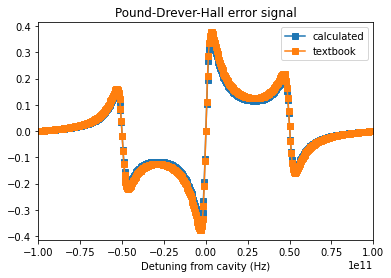

In [544]:
# Alright, now I'm just going to calculate the amplitude of my error signal at different detunings from the cavity and compare to the textbook shape
# This cell will take 2 x len(det_cav) seconds to evaluate. With current settings, this works out to something like 800 seconds (evaluate with caution!).
start_det = -2*Omega
stop_det = 2*Omega
step_det = Omega/100.0
det_cav = np.arange(start_det, stop_det, step_det)
PDH_error = 0*det_cav
phase_ram = 0
amp_ram = 0
for i in range(len(det_cav)): 
    PDH_error[i] = PDH(t, r, f_0, FSR2, Omega, J_0, J_1, det_cav[i], amp_ram, phase_ram)
plt.figure()
plt.plot(det_cav,PDH_error, '-s', label = "calculated")
# Let's compare to the textbook answer
F_c = RefCoeff(r,det_cav,FSR2)
F_s1 = RefCoeff(r,det_cav-Omega,FSR2)
F_s2 = RefCoeff(r,det_cav+Omega,FSR2)
Error_textbook = -2*np.sqrt(J_0*J_1)*np.imag(F_c*np.conjugate(F_s2) - np.conjugate(F_c)*F_s1)/np.pi
plt.plot(det_cav,Error_textbook, '-s', label = "textbook")
plt.xlim(start_det, stop_det)
plt.legend()
plt.title("Pound-Drever-Hall error signal")
plt.xlabel("Detuning from cavity (Hz)")
plt.show()

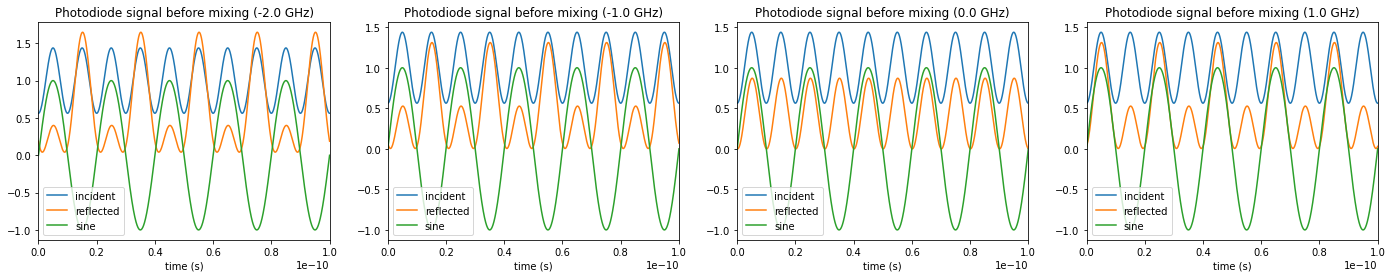

In [556]:
# To give you a bit more intuition about what is happening, let me vary the detuning and show you the photodiode signal before mixing.
# This cell takes about 15 seconds to evaluate
det_cav = np.array([-2e9, -1e9, 0, 1e9])

E_inc = J_0*np.exp(1j*2*np.pi*(f_0)*t) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t) - J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)

def ReflectedIntensity(J_0,J_1, f_0, t, FSR, det_cav, Omega):
    A = J_0*np.exp(1j*2*np.pi*(f_0)*t)*RefCoeff(r,f_0-det_cav,FSR2) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t)*RefCoeff(r,f_0+Omega-det_cav,FSR2) \
    - J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)*RefCoeff(r,f_0-Omega-det_cav,FSR2)
    return(np.real(A*np.conjugate(A)))

fig7,axes7 = plt.subplots(1,4,figsize=(24,4))
k = 0
axes7[k].plot(t,np.real(E_inc*np.conjugate(E_inc)), label = "incident")
axes7[k].plot(t,ReflectedIntensity(J_0,J_1, f_0, t, FSR2, det_cav[k], Omega), label = "reflected")
axes7[k].plot(t,np.sin(2*np.pi*Omega*t), label = "sine")
axes7[k].set_xlim(0,1e-10)
axes7[k].set_title("Photodiode signal before mixing (%1.1f GHz)" %(det_cav[k]/1e9))
axes7[k].set_xlabel("time (s)")
axes7[k].legend(loc = "lower left")

k = 1
axes7[k].plot(t,np.real(E_inc*np.conjugate(E_inc)), label = "incident")
axes7[k].plot(t,ReflectedIntensity(J_0,J_1, f_0, t, FSR2, det_cav[k], Omega), label = "reflected")
axes7[k].plot(t,np.sin(2*np.pi*Omega*t), label = "sine")
axes7[k].set_xlim(0,1e-10)
axes7[k].set_title("Photodiode signal before mixing (%1.1f GHz)" %(det_cav[k]/1e9))
axes7[k].set_xlabel("time (s)")
axes7[k].legend(loc = "lower left")

k = 2
axes7[k].plot(t,np.real(E_inc*np.conjugate(E_inc)), label = "incident")
axes7[k].plot(t,ReflectedIntensity(J_0,J_1, f_0, t, FSR2, det_cav[k], Omega), label = "reflected")
axes7[k].plot(t,np.sin(2*np.pi*Omega*t), label = "sine")
axes7[k].set_xlim(0,1e-10)
axes7[k].set_title("Photodiode signal before mixing (%1.1f GHz)" %(det_cav[k]/1e9))
axes7[k].set_xlabel("time (s)")
axes7[k].legend(loc = "lower left")
                
k = 3
axes7[k].plot(t,np.real(E_inc*np.conjugate(E_inc)), label = "incident")
axes7[k].plot(t,ReflectedIntensity(J_0,J_1, f_0, t, FSR2, det_cav[k], Omega), label = "reflected")
axes7[k].plot(t,np.sin(2*np.pi*Omega*t), label = "sine")
axes7[k].set_xlim(0,1e-10)
axes7[k].set_title("Photodiode signal before mixing (%1.1f GHz)" %(det_cav[k]/1e9))
axes7[k].set_xlabel("time (s)")
axes7[k].legend(loc = "lower left")                  

plt.show()

Basically, for the reflected field off-resonance from the cavity, there is destructive interference between different combinations of the sidebands that prevents any intensity beating at $\Omega$ and instead everything is either DC or oscillating at $2\Omega$. The cavity, however, ruins this subtle balance, by absorbing different sidebands differently and writing different phase shifts onto them (except of course when the cavity is resonant). Thus, whenever the cavity is near near but not exactly on resonance with one of the sidebands or carrier, the intensity envelope develops a beat at $\Omega$ producing an error signal whose amplitude is linear around resonance.

# Residual Amplitude Modulation (RAM)

Error signal without RAM is 0.0
Error signal with RAM is 0.0


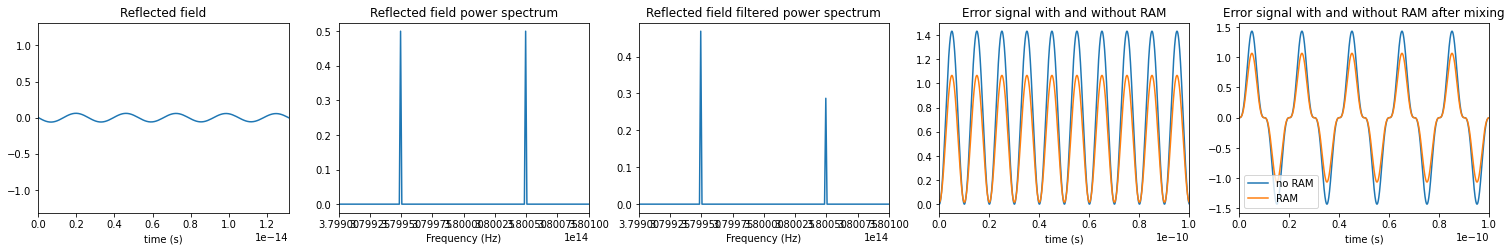

In [39]:
# Residual amplitude modulation occurs when the destructive interference between the sidebands that normally occurs in the absence of any frequency-dependent effects is disrupted.
# Sometimes people talk about RAM as if it occurs simply when the two sidebands are of unequal amplitude. 
# This actually does not cause RAM. 
# Let's work through a brief example to show that this is the case. 
cav_det = 0
E_ref_RAM = J_0*np.exp(1j*2*np.pi*f_0*t)*RefCoeff(r,f_0-cav_det, FSR2) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t)*RefCoeff(r,f_0+Omega - cav_det,FSR2) \
- J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)*RefCoeff(r,f_0 - Omega - cav_det,FSR2)
fig8,axes8 = plt.subplots(1,5,figsize=(26,3.5))
axes8[0].plot(t,np.real(E_ref_RAM))
axes8[0].set_xlim(0,5*T_0)
axes8[0].set_title("Reflected field")
axes8[0].set_xlabel("time (s)")
a, Filtered_ErrorSignal, PwrSpectrum, FilteredPwrSpectrum = FrequencyFilter(t,E_ref_RAM, f_0-25e9, 100e9)
axes8[1].plot(f,PwrSpectrum)
axes8[1].set_xlim(f_0 - 1e11,f_0 + 1e11)
axes8[1].set_title("Reflected field power spectrum")
axes8[1].set_xlabel("Frequency (Hz)")
axes8[2].plot(f,FilteredPwrSpectrum)
axes8[2].set_xlim(f_0 - 1e11,f_0 + 1e11)
axes8[2].set_title("Reflected field filtered power spectrum")
axes8[2].set_xlabel("Frequency (Hz)")
PDsignal_noRAM = np.real(E_ref_RAM*np.conjugate(E_ref_RAM)) 
PDsignal_RAM = np.real(Filtered_ErrorSignal*np.conjugate(Filtered_ErrorSignal)) 
axes8[3].plot(t,PDsignal_noRAM)
axes8[3].plot(t,PDsignal_RAM)
axes8[3].set_xlim(0,1e-10)
axes8[3].set_title("Error signal with and without RAM")
axes8[3].set_xlabel("time (s)")
# The error signal is produced by multiplying the photodiode signal by sin(2 * pi *Omega t)
Error_signal_noRAM = PDsignal_noRAM*np.sin(2*np.pi*Omega*t)
Error_signal_RAM = PDsignal_RAM*np.sin(2*np.pi*Omega*t)
axes8[4].plot(t,Error_signal_noRAM, label = "no RAM")
axes8[4].plot(t,Error_signal_RAM, label = "RAM")
axes8[4].set_title("Error signal with and without RAM after mixing")
axes8[4].set_xlabel("time (s)")
axes8[4].legend(loc = "lower left")                  
axes8[4].set_xlim(0,1e-10)
print("Error signal without RAM is %1.1f" %(np.mean(Error_signal_noRAM)))
print("Error signal with RAM is %1.1f" %(np.mean(Error_signal_RAM)))

Error signal without RAM is 0.000
Error signal with RAM is -0.164


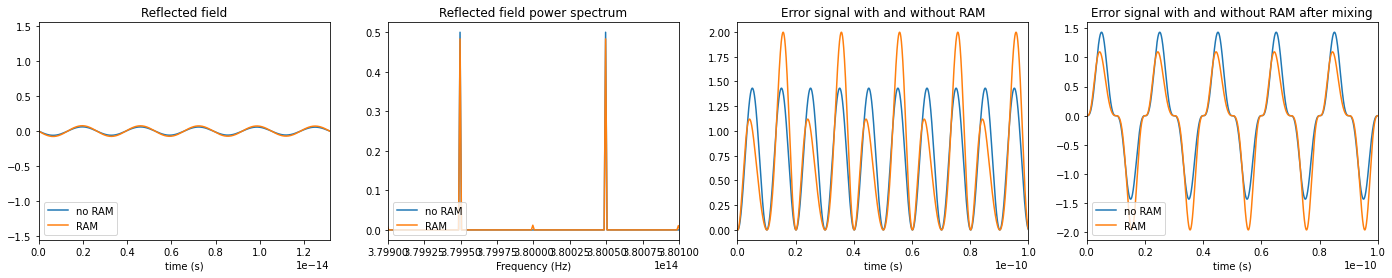

In [48]:
# What does cause RAM is when the electric field amplitude is modulated at the EOM modulation frequency
phi_RAM = .5
a_RAM = .3
E_ref_noRAM = (J_0*np.exp(1j*2*np.pi*f_0*t)*RefCoeff(r,f_0-cav_det, FSR2) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t)*RefCoeff(r,f_0+Omega - cav_det,FSR2) \
- J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)*RefCoeff(r,f_0 - Omega - cav_det,FSR2))*(1 + 0*np.cos(2*np.pi*Omega*t + phi_RAM))
E_ref_RAM = (J_0*np.exp(1j*2*np.pi*f_0*t)*RefCoeff(r,f_0-cav_det, FSR2) + J_1*np.exp(1j*2*np.pi*(f_0 + Omega)*t)*RefCoeff(r,f_0+Omega - cav_det,FSR2) \
- J_1*np.exp(1j*2*np.pi*(f_0 - Omega)*t)*RefCoeff(r,f_0 - Omega - cav_det,FSR2))*(1 + a_RAM*np.cos(2*np.pi*Omega*t + phi_RAM))

fig9,axes9 = plt.subplots(1,4,figsize=(24,4))
axes9[0].plot(t,np.real(E_ref_noRAM), label = "no RAM")
axes9[0].plot(t,np.real(E_ref_RAM), label = "RAM")
axes9[0].set_xlim(0,5*T_0)
axes9[0].set_title("Reflected field")
axes9[0].set_xlabel("time (s)")
axes9[0].legend(loc = "lower left")                  


axes9[1].plot(f,FourierTransform(t,E_ref_noRAM)[1], label = "no RAM")
axes9[1].plot(f,FourierTransform(t,E_ref_RAM)[1], label = "RAM")
axes9[1].set_xlim(f_0 - 1e11,f_0 + 1e11)
axes9[1].set_title("Reflected field power spectrum")
axes9[1].set_xlabel("Frequency (Hz)")
axes9[1].legend(loc = "lower left")                  
                 

PDsignal_noRAM = np.real(E_ref_noRAM*np.conjugate(E_ref_noRAM)) 
PDsignal_RAM = np.real(E_ref_RAM*np.conjugate(E_ref_RAM)) 
axes9[2].plot(t,PDsignal_noRAM)
axes9[2].plot(t,PDsignal_RAM)
axes9[2].set_xlim(0,1e-10)
axes9[2].set_title("Error signal with and without RAM")
axes9[2].set_xlabel("time (s)")

# The error signal is produced by multiplying the photodiode signal by sin(2 * pi *Omega t)
Error_signal_noRAM = PDsignal_noRAM*np.sin(2*np.pi*Omega*t)
Error_signal_RAM = PDsignal_RAM*np.sin(2*np.pi*Omega*t)
axes9[3].plot(t,Error_signal_noRAM, label = "no RAM")
axes9[3].plot(t,Error_signal_RAM, label = "RAM")
axes9[3].set_title("Error signal with and without RAM after mixing")
axes9[3].set_xlabel("time (s)")
axes9[3].legend(loc = "lower left")                  
axes9[3].set_xlim(0,1e-10)
print("Error signal without RAM is %1.3f" %(np.mean(Error_signal_noRAM)))
print("Error signal with RAM is %1.3f" %(np.mean(Error_signal_RAM)))

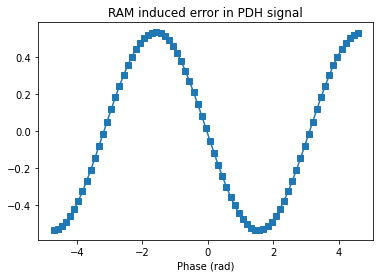

In [17]:
# Alright, now I'm just going to calculate the amplitude of my error signal on resonance as a function of phase (any non-zero value is a RAM-induced error). 
det_cav = 0
amp_RAM = 0.5
start_phase = -1.5*np.pi
stop_phase = 1.5*np.pi
step_phase = np.pi/25.0
phase_RAM = np.arange(start_phase, stop_phase, step_phase)
PDH_error_RAM = 0*phase_RAM
for i in range(len(phase_RAM)): 
    PDH_error_RAM[i] = PDH(t, r, f_0, FSR2, Omega, J_0, J_1, det_cav, amp_RAM, phase_RAM[i])
plt.figure()
plt.plot(phase_RAM,PDH_error_RAM, '-s', label = "calculated")
# Let's compare to the textbook answer
plt.title("RAM induced error in PDH signal")
plt.xlabel("Phase (rad)")
plt.show()

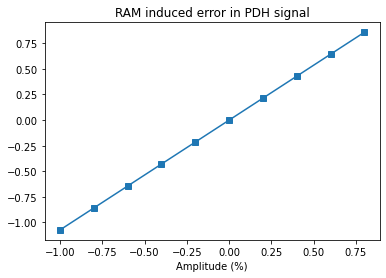

In [14]:
# Alright, now I'm just going to calculate the amplitude of my error signal on resonance as a function of amplitude amplitude (any non-zero value is a RAM-induced error).
det_cav = 0
phase_RAM = -np.pi/2
start_amp = -1
stop_amp = 1
step_amp = 1/5.0
amp_RAM = np.arange(start_amp, stop_amp, step_amp)
PDH_error_RAM = 0*amp_RAM
for i in range(len(amp_RAM)): 
    PDH_error_RAM[i] = PDH(t, r, f_0, FSR2, Omega, J_0, J_1, det_cav, amp_RAM[i], phase_RAM)
plt.figure()
plt.plot(amp_RAM,PDH_error_RAM, '-s', label = "calculated")
# Let's compare to the textbook answer
plt.title("RAM induced error in PDH signal")
plt.xlabel("Amplitude (%)")
plt.show()